In [1]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import warnings


warnings.filterwarnings("ignore")

In [3]:
#Downloading dataset form https://davidcard.berkeley.edu/data_sets.html

columns = [
    'SHEET', 'CHAIN', 'CO_OWNED', 'STATE', 'SOUTHJ', 'CENTRALJ', 'NORTHJ', 
    'PA1', 'PA2', 'SHORE', 'NCALLS', 'EMPFT', 'EMPPT', 'NMGRS', 'WAGE_ST', 
    'INCTIME', 'FIRSTINC', 'BONUS', 'PCTAFF', 'MEALS', 'OPEN', 'HRSOPEN', 
    'PSODA', 'PFRY', 'PENTREE', 'NREGS', 'NREGS11', 'TYPE2', 'STATUS2', 
    'DATE2', 'NCALLS2', 'EMPFT2', 'EMPPT2', 'NMGRS2', 'WAGE_ST2', 'INCTIME2', 
    'FIRSTINC2', 'SPECIAL2', 'MEALS2', 'OPEN2', 'HRSOPEN2', 'PSODA2', 
    'PFRY2', 'PENTREE2', 'NREGS2', 'NREGS12'
]


try:
    df_raw = pd.read_csv(
        'public.dat', 
        names=columns, 
        delim_whitespace=True, 
        na_values=['.']
    )
    print("Data Load completed successfully.")
    
except FileNotFoundError:
    print("dataset file not found")
    raise

Data Load completed successfully.


In [4]:
df_raw.head()

,SHEET,CHAIN,CO_OWNED,STATE,SOUTHJ,CENTRALJ,NORTHJ,PA1,PA2,SHORE,...,FIRSTINC2,SPECIAL2,MEALS2,OPEN2,HRSOPEN2,PSODA2,PFRY2,PENTREE2,NREGS2,NREGS12
0,46,1,0,0,0,0,0,1,0,0,...,0.08,1.0,2.0,6.5,16.5,1.03,NaN,0.94,4.0,4.0
1,49,2,0,0,0,0,0,1,0,0,...,0.05,0.0,2.0,10.0,13.0,1.01,0.89,2.35,4.0,4.0
2,506,2,1,0,0,0,0,1,0,0,...,0.25,NaN,1.0,11.0,11.0,0.95,0.74,2.33,4.0,3.0
3,56,4,1,0,0,0,0,1,0,0,...,0.15,0.0,2.0,10.0,12.0,0.92,0.79,0.87,2.0,2.0
4,61,4,1,0,0,0,0,1,0,0,...,0.15,0.0,2.0,10.0,12.0,1.01,0.84,0.95,2.0,2.0


In [6]:
# Data Cleaning & Feature Engineering

# The Card & Krueger paper defines "Full-Time Equivalent" (FTE) employment as:
# FTE = FullTime + Managers + (0.5 * PartTime)

# Pre-Intervention FTE (Wave 1)
df_raw['fte_pre'] = df_raw['EMPFT'] + df_raw['NMGRS'] + (0.5 * df_raw['EMPPT'])

# Post-Intervention FTE (Wave 2)
df_raw['fte_post'] = df_raw['EMPFT2'] + df_raw['NMGRS2'] + (0.5 * df_raw['EMPPT2'])

# Create a clean DataFrame for analysis (Wide to Long format conversion)

# 1. Create the "Pre" dataset (Time = 0)
df_pre = df_raw[['STATE', 'fte_pre']].copy()
df_pre = df_pre.rename(columns={'fte_pre': 'employment'})
df_pre['post'] = 0
df_pre['treated'] = df_raw['STATE'] # 1 if NJ (Treated), 0 if PA (Control)

# 2. Create the "Post" dataset (Time = 1)
df_post = df_raw[['STATE', 'fte_post']].copy()
df_post = df_post.rename(columns={'fte_post': 'employment'})
df_post['post'] = 1
df_post['treated'] = df_raw['STATE']

# 3. Combine them
data = pd.concat([df_pre, df_post], ignore_index=True)

# Drop missing values (stores that closed or didn't respond in one wave)
data = data.dropna()

print(f"Data Processed. Final shape: {data.shape}")

Data Processed. Final shape: (794, 4)


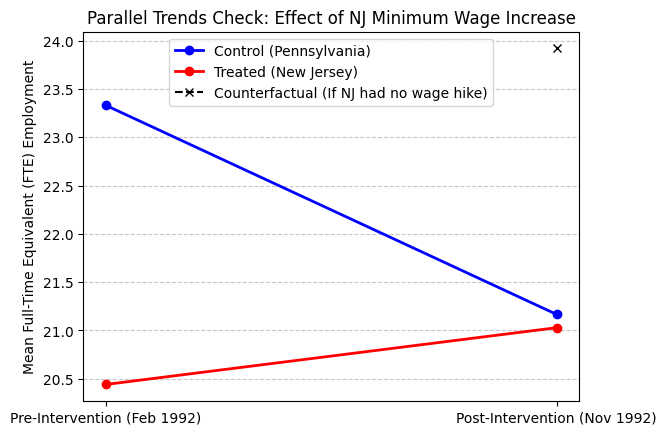

Parallel Trends Visualized.


In [7]:
# Assumption Check: Visualizing Parallel Trends

# Calculate mean employment by group and time
mean_emp = data.groupby(['treated', 'post'])['employment'].mean().reset_index()

# Extract means for plotting
nj_pre = mean_emp[(mean_emp['treated'] == 1) & (mean_emp['post'] == 0)]['employment'].iloc[0]
nj_post = mean_emp[(mean_emp['treated'] == 1) & (mean_emp['post'] == 1)]['employment'].iloc[0]
pa_pre = mean_emp[(mean_emp['treated'] == 0) & (mean_emp['post'] == 0)]['employment'].iloc[0]
pa_post = mean_emp[(mean_emp['treated'] == 0) & (mean_emp['post'] == 1)]['employment'].iloc[0]

# Plotting the trends
plt.plot([0, 1], [pa_pre, pa_post], marker='o', label='Control (Pennsylvania)', color='blue', linewidth=2)
plt.plot([0, 1], [nj_pre, nj_post], marker='o', label='Treated (New Jersey)', color='red', linewidth=2)
plt.plot([1], [nj_post - (nj_pre - pa_pre)], marker='x', color='black', linestyle='--', label='Counterfactual (If NJ had no wage hike)')

plt.xticks([0, 1], ['Pre-Intervention (Feb 1992)', 'Post-Intervention (Nov 1992)'])
plt.ylabel('Mean Full-Time Equivalent (FTE) Employment')
plt.title('Parallel Trends Check: Effect of NJ Minimum Wage Increase')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

print("Parallel Trends Visualized.")

In [8]:
# DiD Model Formula: Y = beta0 + beta1*Treated + beta2*Post + delta*(Treated*Post)
model_formula = 'employment ~ treated + post + treated:post'

did_model = smf.ols(formula=model_formula, data=data).fit()
did_coefficient = did_model.params['treated:post']

print("\nDifference-in-Differences Results")
print(did_model.summary().tables[1])

print(f"\nDiD Causal Estimate: {did_coefficient:.4f}")

# Interpretation
print("\n--- Interpretation ---")
if did_model.pvalues['treated:post'] < 0.05:
    print(f"The result IS statistically significant. The wage hike caused a change of {did_coefficient:.2f} in employment.")
else:
    print(f"The result is NOT statistically significant (p = {did_model.pvalues['treated:post']:.3f}).")
    print(f"This supports Card & Krueger's famous finding: Increasing the minimum wage did NOT reduce employment (estimate is {did_coefficient:.2f}).")


Difference-in-Differences Results
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       23.3312      1.072     21.767      0.000      21.227      25.435
treated         -2.8918      1.194     -2.423      0.016      -5.235      -0.549
post            -2.1656      1.516     -1.429      0.154      -5.141       0.810
treated:post     2.7536      1.688      1.631      0.103      -0.561       6.068

DiD Causal Estimate: 2.7536

--- Interpretation ---
The result is NOT statistically significant (p = 0.103).
This supports Card & Krueger's famous finding: Increasing the minimum wage did NOT reduce employment (estimate is 2.75).
